# Differential Privacy project

## Alexandros Matakos 015538460

For the project I decided to try and improve the results of the "Skin Cancer: Malignant vs. Benign" study we saw in the lectures, and to try to improve the results both in terms of accuracy and privacy. I am relying on this notebook for the data preparation https://github.com/RuchitaSuranagi/Skin-Cancer-Classifier/blob/main/Malignant_vs_Benign_DP_Opacus_Skin_Cancer_Classification.ipynb, and the model is a modification of the MNIST model from the previous exercise. 

The reported test accuracy was 80.33 and $\epsilon=$47.58, which practically means 0 differential privacy, and was the motivation for the project. 

I uploaded the dataset to this github repo: https://github.com/amatakos/project2-TML, so if you wish to rerun the notebook I suggest you download it from there and put it in the main directory.

Admittingly, y results were not what I hoped for, and I suspect a more complex model would be required, but it was nevertheless quite fun trying to implement a simple CNN for this task, and I believe this also allowed me to have lower $\epsilon$ values. 

My best results were the following: \
**Accuracy = 78.1\%** \
**$\epsilon$ = 22.92** 

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os, cv2
from sklearn.model_selection import train_test_split
import zipfile 
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import opacus
from torch.utils.data import TensorDataset, DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

# suppress useless warnings
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123456789)
torch.manual_seed(123456789)

In [3]:
### Directory containing data
data_dir = 'data/train'

all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

In [4]:
def compute_img_mean_std(image_paths):
#computing the mean and std of three channel on the whole dataset,
#first we should normalize the image


    img_h, img_w = 224, 224
    imgs = []
    NORM_MEAN, NORM_STD_DEV = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        NORM_MEAN.append(np.mean(pixels))
        NORM_STD_DEV.append(np.std(pixels))

    NORM_MEAN.reverse()  # BGR --> RGB
    NORM_STD_DEV.reverse()

    print("NORM_MEAN = {}".format(NORM_MEAN))
    print("NORM_STD_DEV = {}".format(NORM_STD_DEV))
    return NORM_MEAN,NORM_STD_DEV

norm_mean, norm_std_dev = compute_img_mean_std(all_image_path)

100%|█████████████████████████████████████████████████████████████████████████████| 2637/2637 [00:13<00:00, 200.67it/s]


(224, 224, 3, 2637)
NORM_MEAN = [0.7602244, 0.5367321, 0.5379262]
NORM_STD_DEV = [0.15167443, 0.1600644, 0.17655712]


### Transform images and create datasets

In [7]:
image_transforms = {
    "train": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std_dev)
]),
    "test": transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std_dev)
])}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

# Create datasets
train_dataset = datasets.ImageFolder(root = 'data/train', transform = image_transforms["train"])
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Create a list of indices from 0 to length of dataset.
dataset_size = len(train_dataset)
dataset_indices = list(range(dataset_size))
#Shuffle the list of indices
np.random.shuffle(dataset_indices)

train_idx = dataset_indices[ 0 : int(np.floor(dataset_size))]
train_sampler = SubsetRandomSampler(train_idx)
test_dataset = datasets.ImageFolder(root = 'data/test', transform = image_transforms["test"])
test_dataset

Dataset ImageFolder
    Number of datapoints: 660
    Root location: data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.7602244, 0.5367321, 0.5379262], std=[0.15167443, 0.1600644, 0.17655712])
           )

### Hyperparameters

In [8]:
# Hyperparameters
clip_bound = 2.8
noise_multiplier = .48
delta = 1e-5
sample_rate = 0.05
learning_rate = 0.01
batch_size = 64
num_epochs = 5

### Data Loaders

In [9]:
def create_data_loaders(train_dataset, test_dataset, sample_rate, batch_size, random_seed=4732842):
    train_loader = DataLoader(
        train_dataset,
        batch_size=int(len(train_dataset) * sample_rate),
        generator=torch.Generator().manual_seed(random_seed),
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, sample_rate, batch_size)

### Model class

In [10]:
class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 16, 4, padding=2)
        self.conv2 = nn.Conv2d(16, 32, 8, 3)
        self.conv3 = nn.Conv2d(32, 64, 4, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 2)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        # x of shape [B, 3, 224, 224]
        x = F.relu(self.conv1(x))  # -> [B, 16, 54, 54]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 53, 53]
        x = F.relu(self.conv2(x))  # -> [B, 32, 16, 16]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 15, 15]
        x = F.relu(self.conv3(x))  # -> [B, 32, 6, 6]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 5, 5]
        x = x.view(-1, 64 * 5 * 5)  # -> [B, 1024]
        x = F.relu(self.fc1(x))  # -> [B, 64]
        x = self.fc2(x)  # -> [B, 2]
        return x
    
    @staticmethod
    def train_step(model, batch):
        x, y = batch
        # x, y = x.type(torch.LongTensor), y.type(torch.LongTensor)
        out = model(x)
        loss = model.loss(out, y)
        return loss

    @staticmethod
    def test_step(model, batch):
        x, y = batch
        # x, y = x.type(torch.LongTensor), y.type(torch.LongTensor)
        out = model(x)
        loss = model.loss(out, y)
        pred = out.argmax(dim=1, keepdim=True)#.type(torch.LongTensor)
        corrects = pred.eq(y.view_as(pred)).sum().item()
        #preds = out > 0 # Predict y = 1 if P(y = 1) > 0.5
        #corrects = torch.tensor(torch.sum(preds == y).item())
        return loss, corrects

### Train/test routines

In [11]:
def train(model, train_loader, opt_func, learning_rate, num_epochs, noise_multiplier, clip_bound, delta, verbose=False, random_seed=474237):
    optimizer = opt_func(model.parameters(), learning_rate)
    privacy_engine = opacus.PrivacyEngine(
        accountant="rdp", # Use RDP-based accounting
        secure_mode=False, # Should be set to True for production use
    )
    rng = torch.Generator()
    rng.manual_seed(int(random_seed))
    model_type = type(model)
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_bound,
        noise_generator=rng,
        loss_reduction="mean"
    )

    for epoch in range(num_epochs):
        losses = []
        for batch in train_loader:
            loss = model_type.train_step(model, batch)
            loss.backward()
            losses.append(loss)
            optimizer.step()
            optimizer.zero_grad()
        
        if verbose:
            print("Epoch {}, loss = {}".format(epoch + 1, torch.sum(loss) / len(train_loader)))

    # epsilon, alpha = optimizer.privacy_engine.get_privacy_spent(delta)
    epsilon = privacy_engine.get_epsilon(delta)
    return epsilon

def test(model, test_loader):
    with torch.no_grad():
        losses = []
        accuracies = []
        total_size = 0
        for batch in test_loader:
            total_size += len(batch[1])
            loss, corrects = model.test_step(model, batch)
            losses.append(loss)
            accuracies.append(corrects)

        average_loss = np.array(loss).sum() / total_size
        total_accuracy = np.array(accuracies).sum() / total_size
        return average_loss, total_accuracy

### Some example images (with colorshift)

11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11/27/2022 23:01:05:WARNING:Clippi

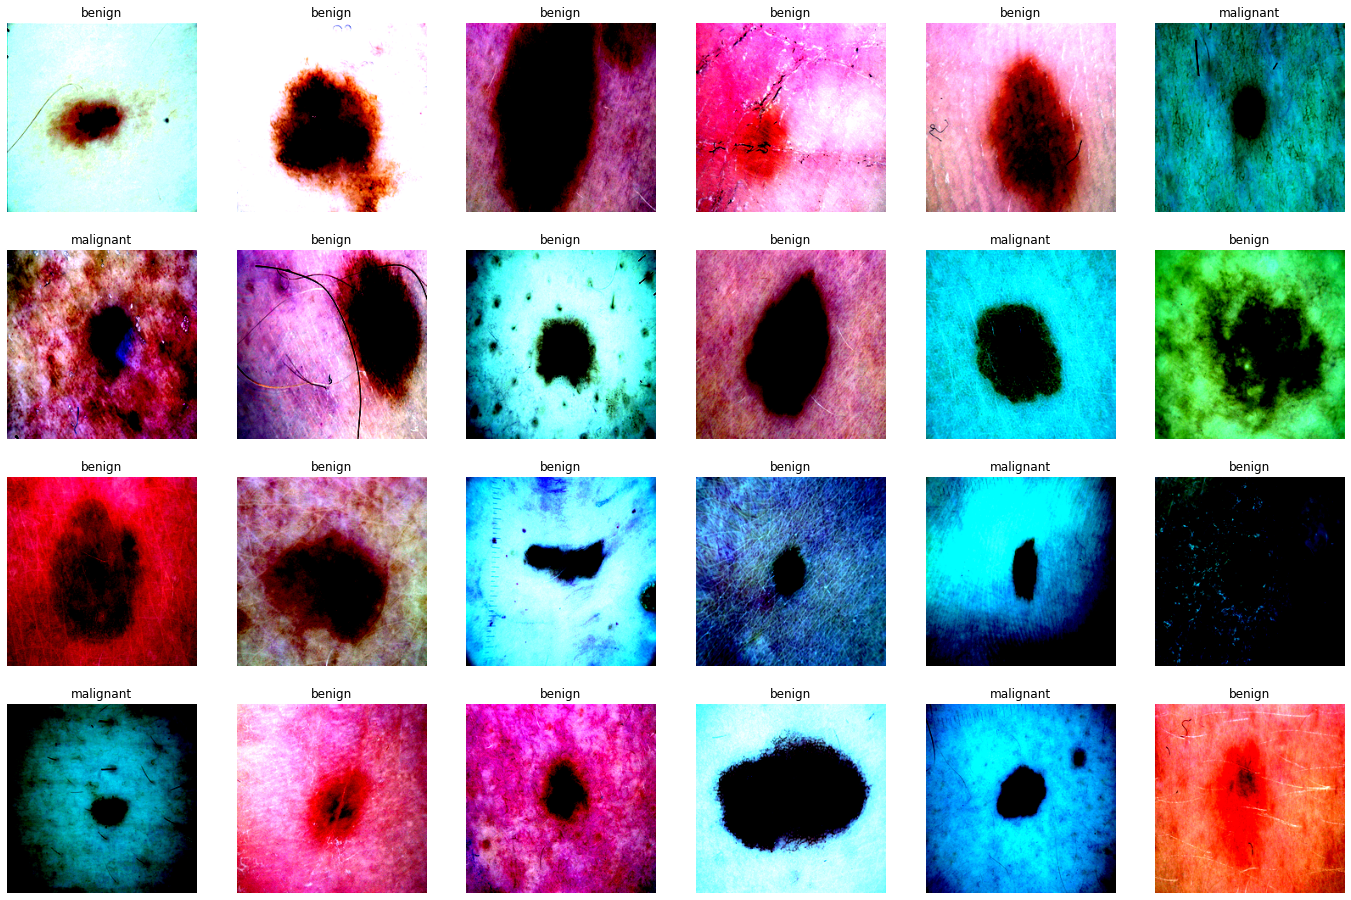

In [17]:
for samples, _ in test_loader:
    samples = samples
    break
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'benign', 1:'malignant'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))

### Train the model

In [12]:
model = SampleConvNet()
epsilon = train(
    model, train_loader, torch.optim.SGD, learning_rate, num_epochs,
    noise_multiplier, clip_bound, delta, verbose=True
)
print("Epsilon: {}, Delta: {}".format(epsilon, delta))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.03291086480021477
Epoch 2, loss = 0.031593743711709976
Epoch 3, loss = 0.027473602443933487
Epoch 4, loss = 0.03187815472483635
Epoch 5, loss = 0.025676732882857323
Epsilon: 22.927291272588675, Delta: 1e-05
Loss: 0.001060644695253083, Accuracy: 0.7106060606060606


### Accuracy is not bad, but it's lower than the paper's, and even though $\epsilon$ is smaller, it's still quite high.

We play around with the hyperparameters to improve it.

In [18]:
# Hyperparameters
clip_bound = 0.8
noise_multiplier = 1.
delta = 1e-5
sample_rate = 0.03
learning_rate = 0.01
batch_size = 64
num_epochs = 10

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, sample_rate, batch_size)

# Retrain with new hyperparameters
model = SampleConvNet()
epsilon = train(
    model, train_loader, torch.optim.SGD, learning_rate, num_epochs,
    noise_multiplier, clip_bound, delta, verbose=True
)
print("Epsilon: {}, Delta: {}".format(epsilon, delta))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.020419657230377197
Epoch 2, loss = 0.020335638895630836
Epoch 3, loss = 0.02013544738292694
Epoch 4, loss = 0.020056113600730896
Epoch 5, loss = 0.019764963537454605
Epoch 6, loss = 0.018944919109344482
Epoch 7, loss = 0.01899484544992447
Epoch 8, loss = 0.022424140945076942
Epoch 9, loss = 0.01960025355219841
Epoch 10, loss = 0.024403490126132965
Epsilon: 3.9452283733553113, Delta: 1e-05
Loss: 0.0024523225697604093, Accuracy: 0.5484848484848485


### Epsilon is now lower, but accuracy suffered quite a lot.

In [19]:
# Hyperparameters
clip_bound = 1.5
noise_multiplier = 0.41
delta = 1e-5
sample_rate = 0.1
learning_rate = 0.02
batch_size = 64
num_epochs = 5

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, sample_rate, batch_size)

# Retrain with new hyperparameters
model = SampleConvNet()
epsilon = train(
    model, train_loader, torch.optim.SGD, learning_rate, num_epochs,
    noise_multiplier, clip_bound, delta, verbose=True
)
print("Epsilon: {}, Delta: {}".format(epsilon, delta))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.062479425221681595
Epoch 2, loss = 0.05973133072257042
Epoch 3, loss = 0.06303625553846359
Epoch 4, loss = 0.07077925652265549
Epoch 5, loss = 0.06700113415718079
Epsilon: 39.60906481362386, Delta: 1e-05
Loss: 0.0026836635488452333, Accuracy: 0.5454545454545454


### No improvement in accuracy from these changes, this is looking hard.

At this step I modified the CNN a bit

In [20]:
# Hyperparameters
clip_bound = 1.5
noise_multiplier = .28
delta = 1e-5
sample_rate = 0.05
learning_rate = 0.01
batch_size = 64
num_epochs = 5

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, sample_rate, batch_size)

# Retrain with new hyperparameters
model = SampleConvNet()
epsilon = train(
    model, train_loader, torch.optim.SGD, learning_rate, num_epochs,
    noise_multiplier, clip_bound, delta, verbose=True
)
print("Epsilon: {}, Delta: {}".format(epsilon, delta))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.032605890184640884
Epoch 2, loss = 0.032276831567287445
Epoch 3, loss = 0.03175296634435654
Epoch 4, loss = 0.032884400337934494
Epoch 5, loss = 0.029732493683695793
Epsilon: 90.11264312084114, Delta: 1e-05
Loss: 0.0015367267709789855, Accuracy: 0.5454545454545454


### Best result I could get below

In [22]:
# Hyperparameters
clip_bound = 2.8
noise_multiplier = .48
delta = 1e-5
sample_rate = 0.05
learning_rate = 0.05
batch_size = 64
num_epochs = 5

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, sample_rate, batch_size)

# Retrain with new hyperparameters
model = SampleConvNet()
epsilon = train(
    model, train_loader, torch.optim.SGD, learning_rate, num_epochs,
    noise_multiplier, clip_bound, delta, verbose=True
)
print("Epsilon: {}, Delta: {}".format(epsilon, delta))
average_loss, total_accuracy = test(model, test_loader)
print("Loss: {}, Accuracy: {}".format(average_loss, total_accuracy))

Epoch 1, loss = 0.02868664264678955
Epoch 2, loss = 0.043644990772008896
Epoch 3, loss = 0.03420607000589371
Epoch 4, loss = 0.03912828117609024
Epoch 5, loss = 0.040571652352809906
Epsilon: 22.927291272588675, Delta: 1e-05
Loss: 0.0004998652320919615, Accuracy: 0.7818181818181819
